# Text Analysis across Multiple Texts

## Part I: Importing Python Packages or Libraries

1. Before beginning, we need to import some packages.

In [39]:
import pathlib
import glob 
import collections
import pandas as pd   
from pathlib import Path

import nltk
from nltk import RegexpTokenizer  

In [40]:
textdir = Path("~/shared/RR-workshop-data/state-of-the-union-dataset/txt").expanduser() 
pathlist = sorted(textdir.glob('*.txt')) 

## II. Create a Dataframe of processed texts

**3. DATAFRAMES:** To enable easier analysis of a corpus of texts, we can store info about each in a **dataframe**. A dataframe in Python is a common data structure enabled with the **pandas** library. It is a two-dimensional data table that stores data in rows and columns. 

Run the code below, and then examine what each portion of the code does (see the "#comments").

In [41]:
from nltk.corpus import stopwords
stop = sorted(stopwords.words('english'))

In [42]:
tokenizer = RegexpTokenizer(r'\w+')
#n=50

txtList=[]
pathlist = sorted(textdir.glob('*.txt'))      # .glob only stores the pathlist temporarily (for some reason), so you need to call it again!2
for path in pathlist:
    fn=path.stem                       #stem returns the filename minus the ".txt" (file extension). 
    pres,year=fn.split("_")            # fn = "1794_Washington" becomes year = "1794" and pres = "Washington"
    with open(path,'r') as f:  
        text1 = f.read()                #opens each file and reads it in as "sotu"
    tokens=tokenizer.tokenize(text1)    # tokenizes "sotu"
    numtoks = len(tokens)             # counts the number of tokens in "sotu"
    ltokens_ns = [tok.lower() for tok in tokens if tok not in stop]
    txtList.append([pres, year, numtoks, tokens, ltokens_ns, text1])   #add this info for "sotu" to a running list for all sotu addresses
       

4. We have thus stored information about each text into a list call `txtList`. Now we want to read in this list of information into a dataframe.

In [43]:
colnames=['pres','year','numtoks','tokens', 'ltoks_ns', 'fulltext']
textdf=pd.DataFrame(txtList, columns=colnames)  #places our completed list of SOTU info in a dataframe
textdf.head(10)                                #prints out the first 10 rows of this dataframe (the default value for head() is 5 rows)

,pres,year,numtoks,tokens,ltoks_ns,fulltext
0,Adams,1797,2060,"[Gentlemen, of, the, Senate, and, Gentlemen, o...","[gentlemen, senate, gentlemen, house, represen...",Gentlemen of the Senate and Gentlemen of the H...
1,Adams,1798,2218,"[Gentlemen, of, the, Senate, and, Gentlemen, o...","[gentlemen, senate, gentlemen, house, represen...",Gentlemen of the Senate and Gentlemen of the H...
2,Adams,1799,1505,"[Gentlemen, of, the, Senate, and, Gentlemen, o...","[gentlemen, senate, gentlemen, house, represen...",Gentlemen of the Senate and Gentlemen of the H...
3,Adams,1800,1374,"[Gentlemen, of, the, Senate, and, Gentlemen, o...","[gentlemen, senate, gentlemen, house, represen...",Gentlemen of the Senate and Gentlemen of the H...
4,Adams,1825,9091,"[Fellow, Citizens, of, the, Senate, and, of, t...","[fellow, citizens, senate, house, representati...",Fellow Citizens of the Senate and of the House...
5,Adams,1826,7852,"[Fellow, Citizens, of, the, Senate, and, of, t...","[fellow, citizens, senate, house, representati...",Fellow Citizens of the Senate and of the House...
6,Adams,1827,7064,"[Fellow, Citizens, of, the, Senate, and, of, t...","[fellow, citizens, senate, house, representati...",Fellow Citizens of the Senate and of the House...
7,Adams,1828,7398,"[Fellow, Citizens, of, the, Senate, and, of, t...","[fellow, citizens, senate, house, representati...",Fellow Citizens of the Senate and of the House...
8,Arthur,1881,3903,"[To, the, Senate, and, House, of, Representati...","[to, senate, house, representatives, united, s...",To the Senate and House of Representatives of ...
9,Arthur,1882,3157,"[To, the, Senate, and, House, of, Representati...","[to, senate, house, representatives, united, s...",To the Senate and House of Representatives of ...


# [Basic Seaborn Viz: bar chart - word length by year]

<Axes: xlabel='year', ylabel='numtoks'>

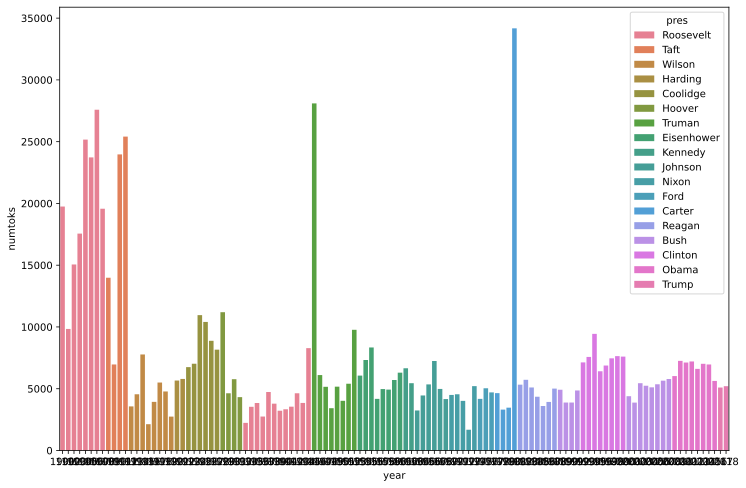

In [44]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]  #changes default figure size to make larger plots
%config InteractiveShellApp.matplotlib = 'inline'
%config InlineBackend.figure_formats = ['svg']

textdf['year'] = textdf['year'].astype(int)
subdf = textdf[textdf['year'] > 1900]
import seaborn as sns
sns.barplot(subdf, x = "year", y = "numtoks", hue = "pres")

# Term Frequency - Inverse Data Frequency (TFIDF)

<img src = "https://miro.medium.com/max/720/1*qQgnyPLDIkUmeZKN2_ZWbQ.webp" style="width:60%">

Image from Yassine Hamdaoui, ["TF(Term Frequency)-IDF(Inverse Document Frequency) from scratch in python"](https://towardsdatascience.com/tf-term-frequency-idf-inverse-document-frequency-from-scratch-in-python-6c2b61b78558) *Towards Data Science (Medium)* (Dec. 9, 2019).

## TF-IDF with Scikit-Learn [MW]

Tf-idf is a method that tries to identify the most distinctively frequent or significant words in a document. 

In this lesson, we’re going to learn how to calculate tf-idf scores using a collection of plain text (.txt) files and the Python library scikit-learn, which has a quick and nifty module called TfidfVectorizer.

In this lesson, we will cover how to:

    Calculate and normalize tf-idf scores for U.S. Inaugural Addresses with scikit-learn


## Breaking Down the TF-IDF Formula [MW]

But first, let’s quickly discuss the tf-idf formula. The idea is pretty simple.

**tf-idf = term_frequency * inverse_document_frequency**

**term_frequency** = number of times a given term appears in document

**inverse_document_frequency** = log(total number of documents / number of documents with term) + 1*****

You take the number of times a term occurs in a document (term frequency). Then you take the number of documents in which the same term occurs at least once divided by the total number of documents (document frequency), and you flip that fraction on its head (inverse document frequency). Then you multiply the two numbers together (term_frequency * inverse_document_frequency).

The reason we take the inverse, or flipped fraction, of document frequency is to boost the rarer words that occur in relatively few documents. Think about the inverse document frequency for the word “said” vs the word “pigeon.” The term “said” appears in 13 (document frequency) of 24 (total documents) Lost in the City stories (24 / 13 –> a smaller inverse document frequency) while the term “pigeons” only occurs in 2 (document frequency) of the 24 stories (total documents) (24 / 2 –> a bigger inverse document frequency, a bigger tf-idf boost).

*There are a bunch of slightly different ways that you can calculate inverse document frequency. The version of idf that we’re going to use is the scikit-learn default, which uses “smoothing” aka it adds a “1” to the numerator and denominator:

**inverse_document_frequency** = log((1 + total_number_of_documents) / (number_of_documents_with_term +1)) + 1

## Part II. Calculate tf-idf [MW]

To calculate tf–idf scores for every word, we’re going to use scikit-learn’s TfidfVectorizer.

4. When you initialize TfidfVectorizer, you can choose to set it with different parameters. These parameters will change the way you calculate tf–idf.

The recommended way to run TfidfVectorizer is with smoothing (smooth_idf = True) and normalization (norm='l2') turned on. These parameters will better account for differences in text length, and overall produce more meaningful tf–idf scores. Smoothing and L2 normalization are actually the default settings for TfidfVectorizer, so to turn them on, you don’t need to include any extra code at all.

Initialize TfidfVectorizer with desired parameters (default smoothing and normalization)

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(input='filename', stop_words='english')

5. Run TfidfVectorizer on our text_files

In [120]:
tfidf_vector = tfidf_vectorizer.fit_transform(pathlist)


<228x24603 sparse matrix of type '<class 'numpy.float64'>'
	with 353332 stored elements in Compressed Sparse Row format>

6. Make a DataFrame out of the resulting tf–idf vector, setting the “feature names” or words as columns and the titles as rows

In [47]:
text_titles = [path.stem for path in pathlist]
#note from Simon: TfidfVectorizer returns a sparse matrix and that's why we have to call .toarray()  before proceeding.
tfidf_df = pd.DataFrame(tfidf_vector.toarray(), index=text_titles, columns=tfidf_vectorizer.get_feature_names_out())
#warning: get_feature_names will be depreciated; use get_feature_names_out instead
   ##I made this fix in the code above
print(tfidf_df)

              00       000  0000  0001  001  002  003  004  005  006  ...  \
Adams_1797   0.0  0.000000   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
Adams_1798   0.0  0.000000   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
Adams_1799   0.0  0.000000   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
Adams_1800   0.0  0.000000   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
Adams_1825   0.0  0.273870   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
...          ...       ...   ...   ...  ...  ...  ...  ...  ...  ...  ...   
Wilson_1916  0.0  0.000000   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
Wilson_1917  0.0  0.000000   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
Wilson_1918  0.0  0.000000   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
Wilson_1919  0.0  0.024088   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
Wilson_1920  0.0  0.205832   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   

             zimbabwe  zimbabwean  zinc  zion  zollverein  zone  zones  \
A

In [48]:
tfidf_df.head()

,00,000,0000,0001,001,002,003,004,005,006,...,zimbabwe,zimbabwean,zinc,zion,zollverein,zone,zones,zoological,zooming,zuloaga
Adams_1797,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Adams_1798,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Adams_1799,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Adams_1800,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Adams_1825,0.0,0.27387,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
tfidf_df['yr'] = tfidf_df.index.str[-4:].astype(int)
tfidf_df['pres'] = tfidf_df.index.str[:-5]
tfidf_df.head()

,00,000,0000,0001,001,002,003,004,005,006,...,zinc,zion,zollverein,zone,zones,zoological,zooming,zuloaga,yr,pres
Adams_1797,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1797,Adams
Adams_1798,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1798,Adams
Adams_1799,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1799,Adams
Adams_1800,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1800,Adams
Adams_1825,0.0,0.27387,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1825,Adams


In [50]:
tfidf_21C = tfidf_df.loc[(tfidf_df['yr'] > 1999),: ]
tfidf_21C.shape

(19, 24605)

In [51]:
#make it a long df
tfidf_21C_metadata = tfidf_21C[["pres", "yr"]]
tfidf_21C_values = tfidf_21C.drop(columns = ["pres", "yr"])
tfidf_21C_values.index.name = "textname"
tfidf_21C_values = tfidf_21C_values.reset_index()
tfidf_21C_values.head()


,textname,00,000,0000,0001,001,002,003,004,005,...,zimbabwe,zimbabwean,zinc,zion,zollverein,zone,zones,zoological,zooming,zuloaga
0,Bush_2001,0.0,0.026655,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Bush_2002,0.0,0.020561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Bush_2003,0.0,0.053320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bush_2004,0.0,0.011373,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Bush_2005,0.0,0.006050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
list(tfidf_21C.columns)

['00',
 '000',
 '0000',
 '0001',
 '001',
 '002',
 '003',
 '004',
 '005',
 '006',
 '007',
 '008',
 '009',
 '01',
 '010',
 '011',
 '0111',
 '012',
 '013',
 '014',
 '015',
 '016',
 '017',
 '018',
 '019',
 '02',
 '020',
 '021',
 '022',
 '023',
 '024',
 '025',
 '026',
 '027',
 '028',
 '029',
 '03',
 '030',
 '031',
 '032',
 '033',
 '034',
 '035',
 '036',
 '037',
 '038',
 '039',
 '04',
 '040',
 '041',
 '042',
 '043',
 '044',
 '045',
 '046',
 '047',
 '048',
 '049',
 '05',
 '050',
 '051',
 '052',
 '053',
 '054',
 '055',
 '056',
 '057',
 '058',
 '059',
 '06',
 '060',
 '061',
 '062',
 '063',
 '064',
 '065',
 '066',
 '067',
 '068',
 '069',
 '07',
 '070',
 '071',
 '072',
 '073',
 '074',
 '075',
 '076',
 '077',
 '078',
 '079',
 '08',
 '080',
 '081',
 '082',
 '083',
 '084',
 '085',
 '086',
 '087',
 '088',
 '089',
 '09',
 '090',
 '0900',
 '091',
 '092',
 '093',
 '094',
 '095',
 '096',
 '097',
 '098',
 '099',
 '10',
 '100',
 '1000',
 '100th',
 '101',
 '102',
 '103',
 '103rd',
 '104',
 '104th',
 '105',


In [53]:
tfidf_long =  pd.melt(tfidf_21C_values, id_vars = "textname", var_name = "word", value_name = "tfidf_score", value_vars = list(tfidf_21C_values.drop(columns = ["textname"]).columns))

In [54]:
tfidf_long.head(30)

,textname,word,tfidf_score
0,Bush_2001,00,0.000000
1,Bush_2002,00,0.000000
2,Bush_2003,00,0.000000
3,Bush_2004,00,0.000000
4,Bush_2005,00,0.000000
5,Bush_2006,00,0.000000
6,Bush_2007,00,0.000000
7,Bush_2008,00,0.000000
8,Clinton_2000,00,0.000000
9,Obama_2009,00,0.000000


In [55]:
textnames = list(tfidf_long['textname'].unique())

In [56]:
""" for text in textnames:
    dfsub = tfidf_long.loc[tfidf_long['textname'] == text,:]
    dfsub = dfsub.sort_values(by = "tfidf_score", ascending = False).iloc[:15,]
    #print(dfsub.head())
    sns.barplot(dfsub, x = "tfidf_score", y = "word") """

' for text in textnames:\n    dfsub = tfidf_long.loc[tfidf_long[\'textname\'] == text,:]\n    dfsub = dfsub.sort_values(by = "tfidf_score", ascending = False).iloc[:15,]\n    #print(dfsub.head())\n    sns.barplot(dfsub, x = "tfidf_score", y = "word") '

In [57]:
#get top 15 tfidf scores for each text
N = 15
tfidf_long = tfidf_long.sort_values(by = "tfidf_score", ascending=False)
print(tfidf_long.shape)
tfidf_sub = tfidf_long.groupby('textname').head(N).reset_index(drop=True)
#textlist = sorted(list(set(tfidf_sub['textname'])))

(467457, 3)


In [58]:
for i, text in enumerate(textnames):
    onetext_df = tfidf_sub[tfidf_sub['textname'] == text]
    print(onetext_df.head())

      textname      word  tfidf_score
9    Bush_2001    budget     0.257244
43   Bush_2001  medicare     0.171726
44   Bush_2001       tax     0.170835
88   Bush_2001    steven     0.138827
102  Bush_2001  americas     0.132215
     textname         word  tfidf_score
14  Bush_2002  afghanistan     0.226542
15  Bush_2002      america     0.224140
22  Bush_2002    terrorist     0.203113
24  Bush_2002       terror     0.196422
41  Bush_2002   terrorists     0.172078
     textname        word  tfidf_score
0   Bush_2003      saddam     0.322795
1   Bush_2003     hussein     0.322795
17  Bush_2003     weapons     0.220477
37  Bush_2003        iraq     0.177158
53  Bush_2003  inspectors     0.161103
     textname        word  tfidf_score
11  Bush_2004        iraq     0.252374
20  Bush_2004     america     0.214153
76  Bush_2004     tonight     0.144449
82  Bush_2004  terrorists     0.142778
93  Bush_2004    marriage     0.135469
     textname        word  tfidf_score
16  Bush_2005        iraq

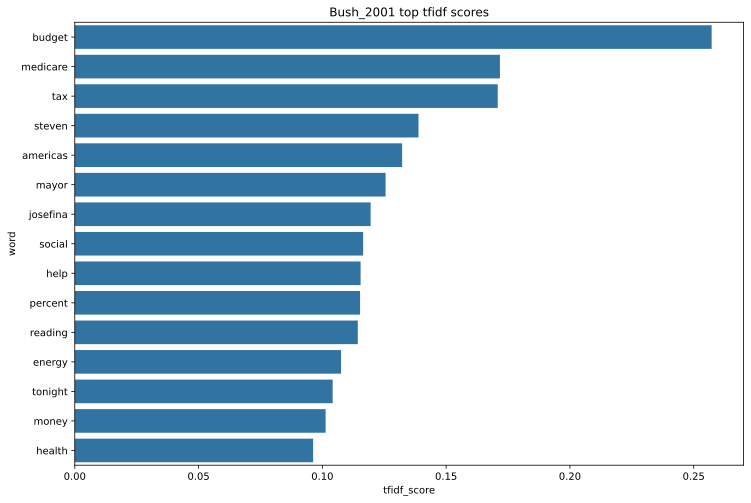

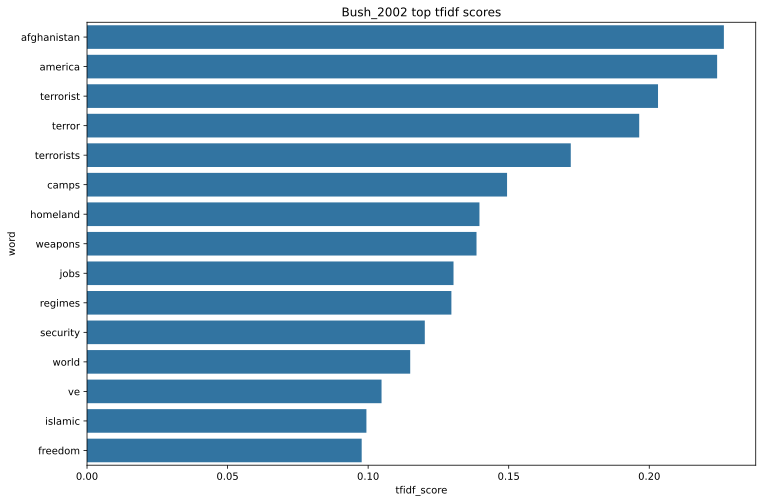

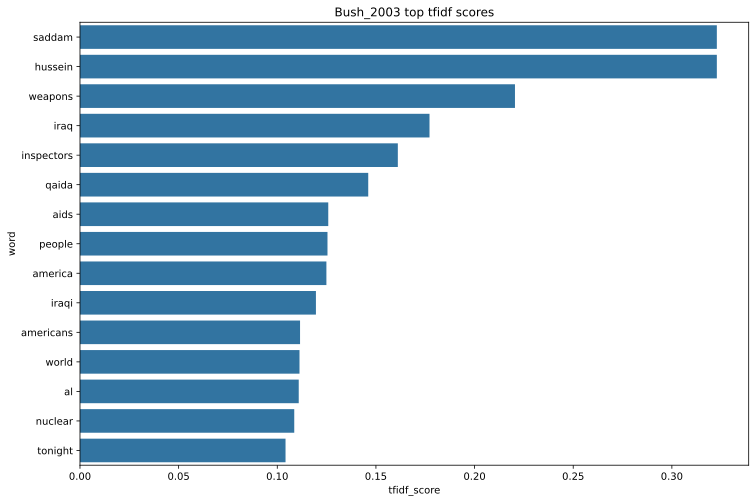

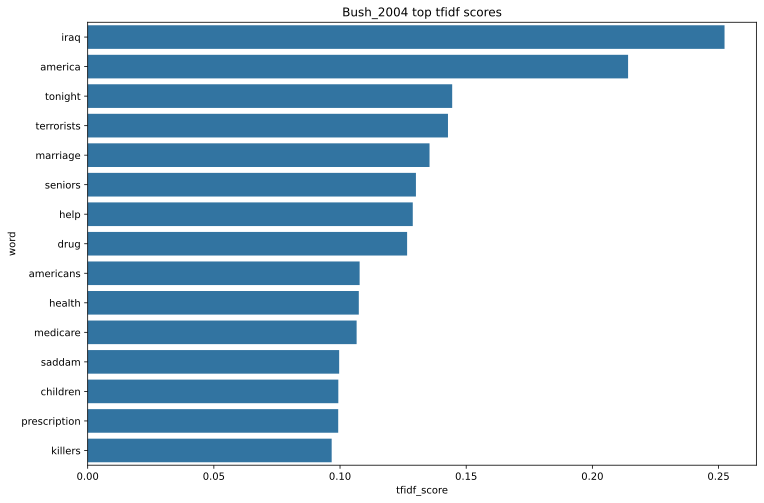

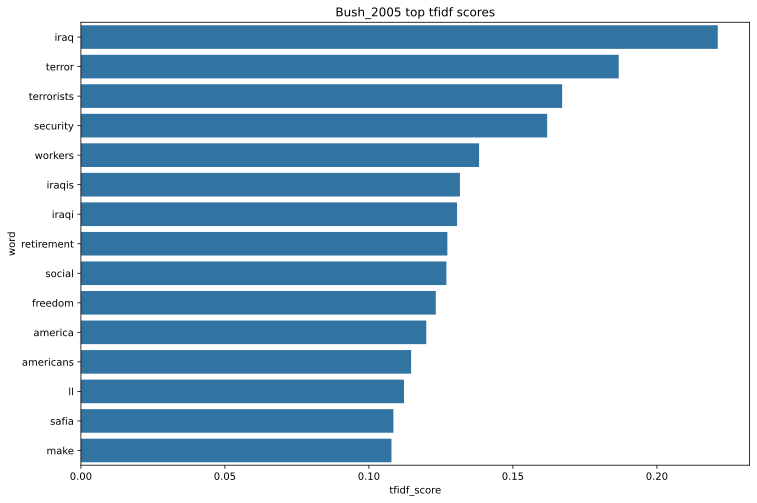

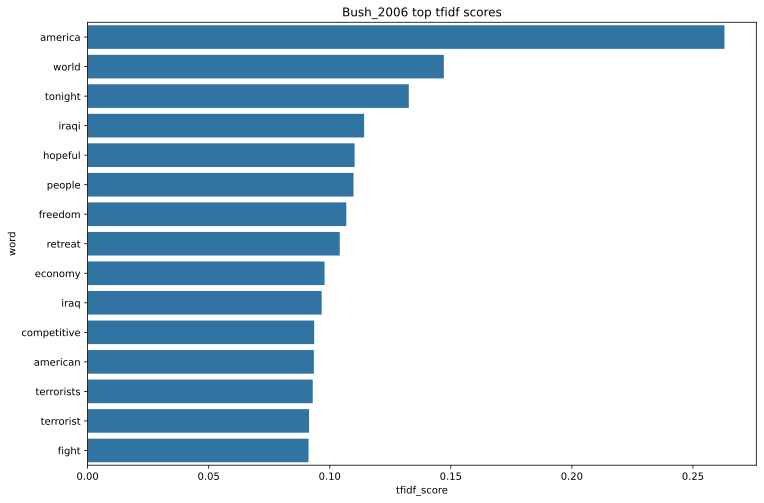

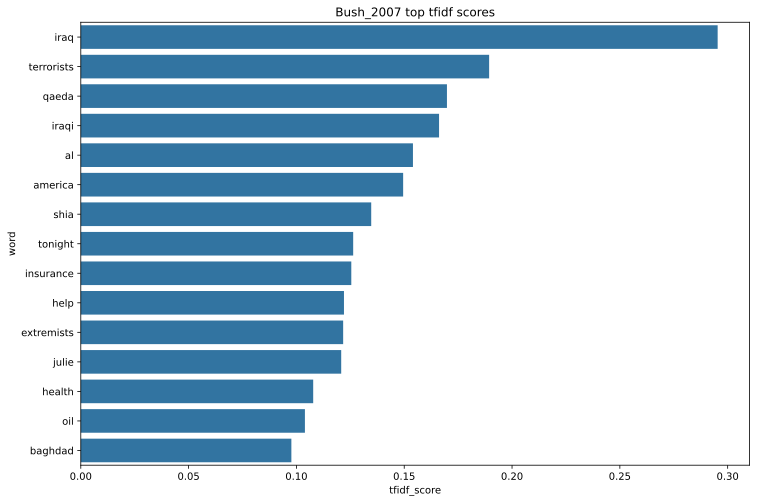

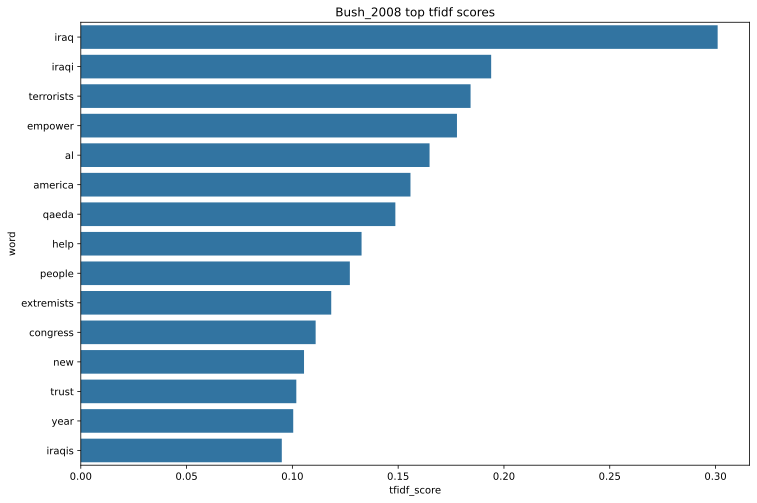

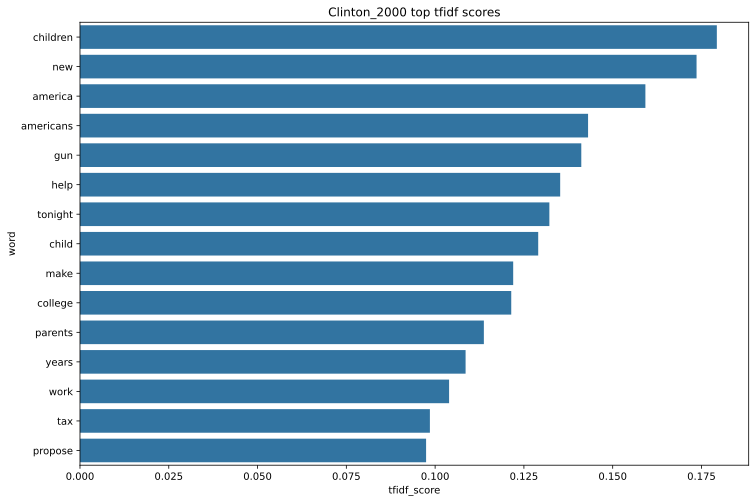

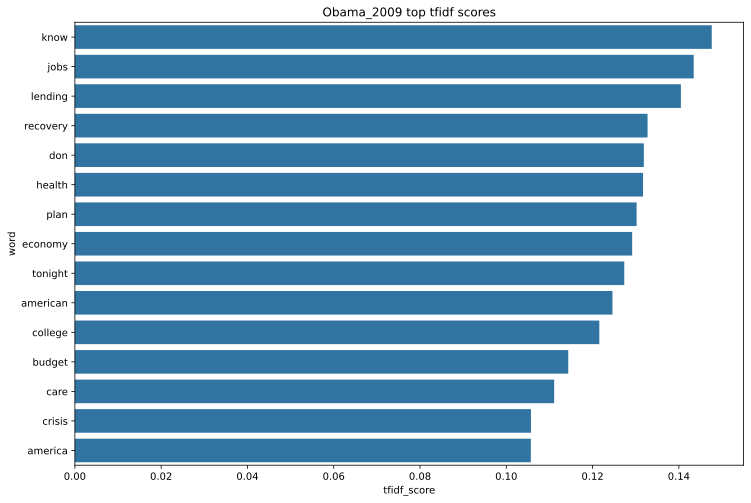

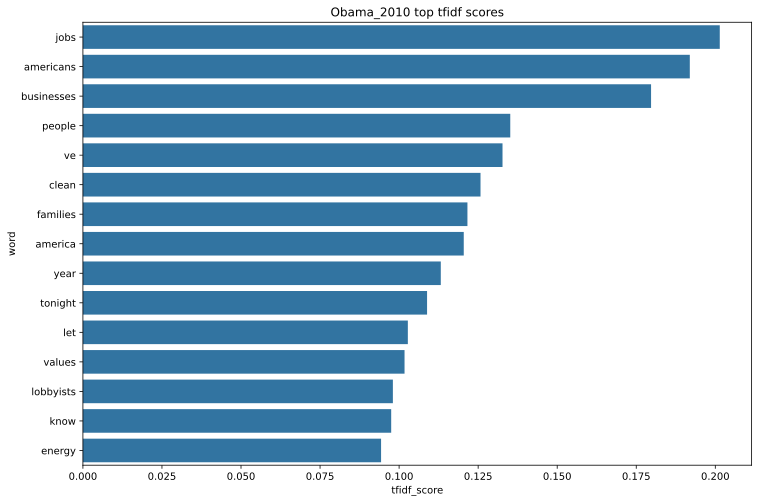

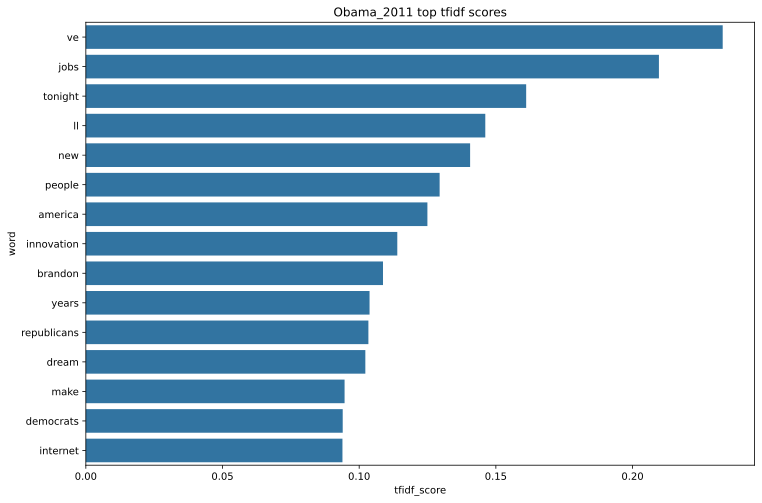

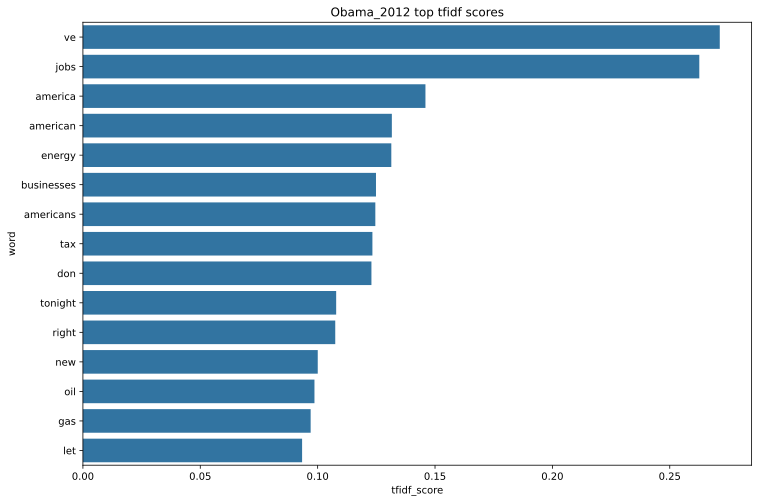

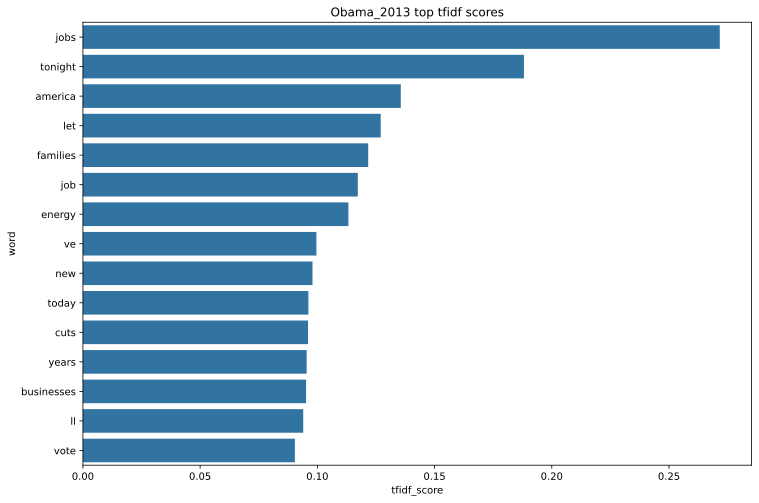

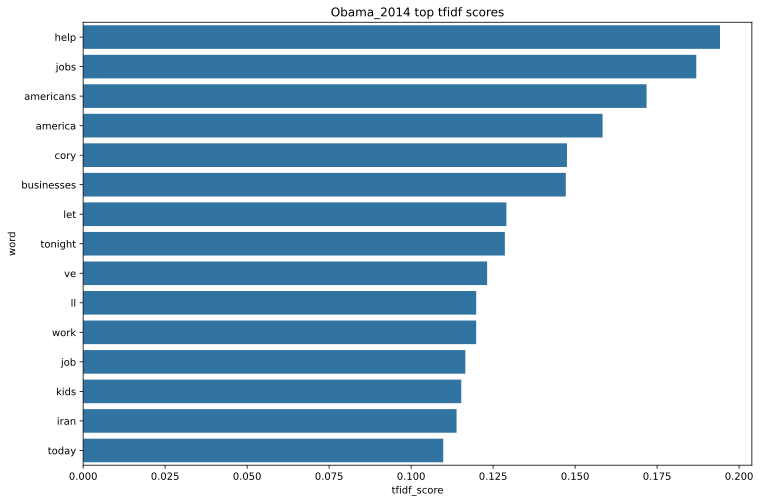

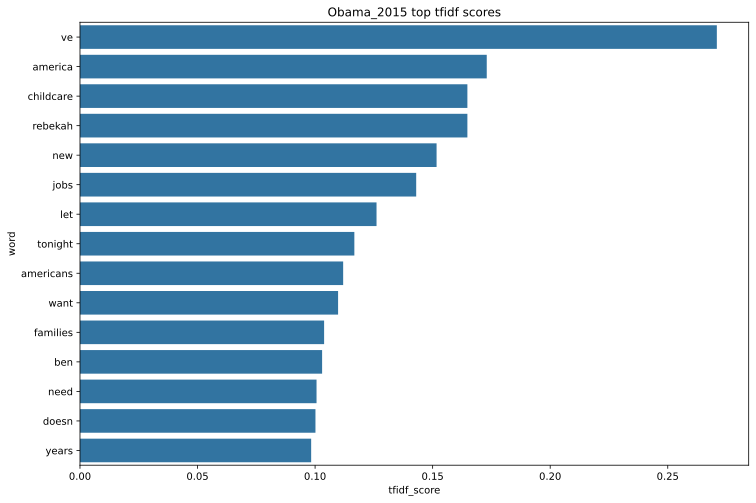

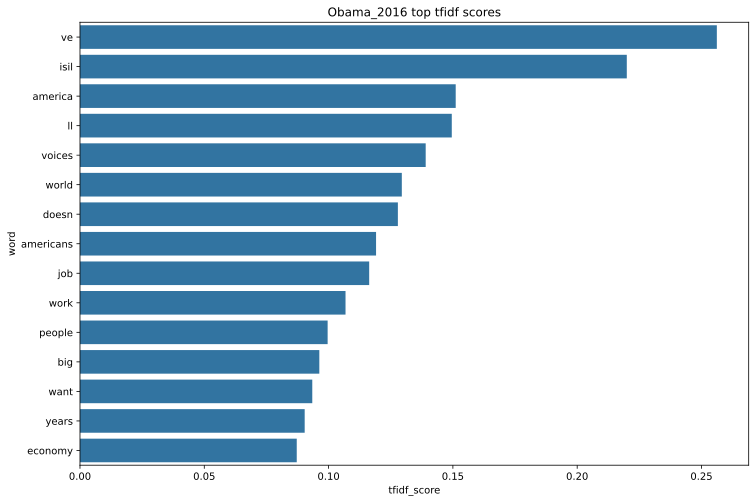

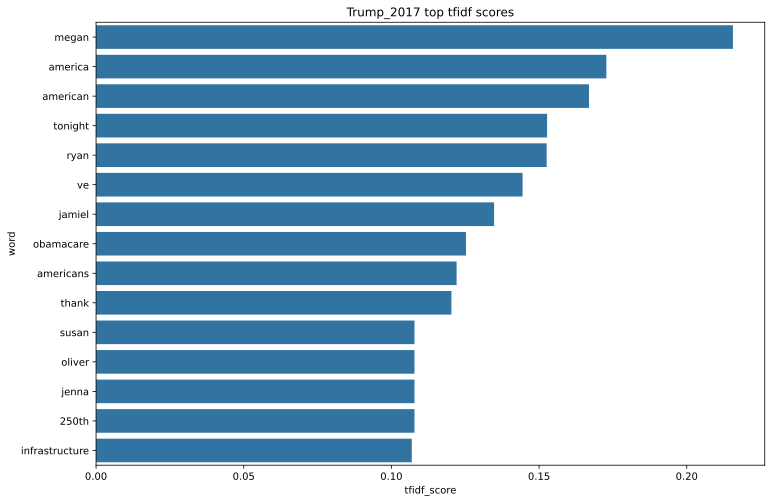

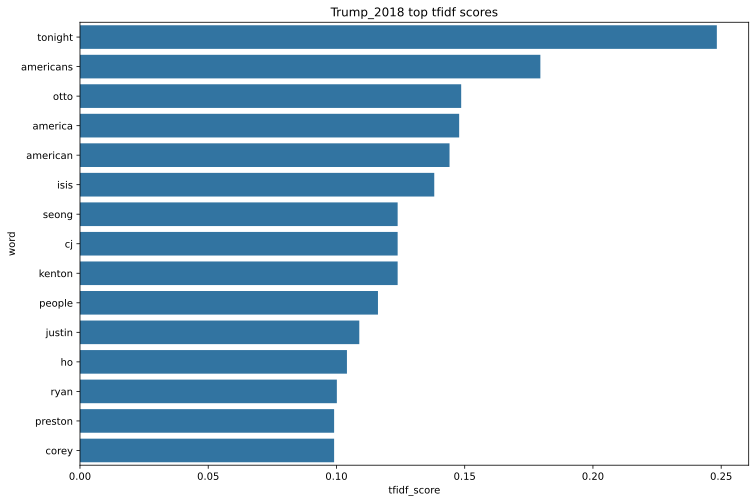

In [87]:
'''
g = sns.FacetGrid(tfidf_sub, row="textname", hue="textname",
                  palette="Set3", aspect=2)
g.map(sns.barplot, 'tfidf_score', 'word')
'''

for i, text in enumerate(textnames):
    onetext_df = tfidf_sub[tfidf_sub['textname'] == text]
    plt.figure(i)
    sns.barplot(onetext_df, x = "tfidf_score", y = "word")
    plt.title(text +' top tfidf scores')
 
    

## [tfidf rankings - see https://programminghistorian.org/en/lessons/analyzing-documents-with-tfidf]

# [some sort of visualization of tfidf??]

# [tfidf for ngrams]

Goal: recreate analysis similar to that in two articles on (fivethirtyeight.com):"
+ Milo Beckman, ["These are the Phrases Each GOP Candidate Repeats the Most"](https://fivethirtyeight.com/features/these-are-the-phrases-each-gop-candidate-repeats-most/) (Mar 10, 2016).
+ Nathaniel Rakich and Dhrumil Mehta, ["The State of the State of the States"](https://fivethirtyeight.com/features/these-are-the-phrases-each-gop-candidate-repeats-most/) (June 13, 2019).

*Question: keep stopwords in? i.e. "war terror" vs. "war on terror"*

In [91]:
tfidf_vectorizer24 = TfidfVectorizer(input='filename', stop_words='english', ngram_range = (2,4))
tfidf_vector24 = tfidf_vectorizer24.fit_transform(pathlist)
tfidf24 = pd.DataFrame(tfidf_vector24.toarray(), index=text_titles, columns=tfidf_vectorizer24.get_feature_names_out())
tfidf24.shape

(228, 2093856)

In [92]:
tfidf24['yr'] = tfidf24.index.str[-4:].astype(int)
tfidf24['pres'] = tfidf24.index.str[:-5]
tfidf24_21C = tfidf24.loc[(tfidf24['yr'] > 1999),: ]
tfidf24_21C_values = tfidf24_21C.drop(columns = ["pres", "yr"])
tfidf24_21C_values.index.name = "textname"
tfidf24_21C_values = tfidf24_21C_values.reset_index()
tfidf24_21C_values.head()

,textname,00 085,00 085 005,00 085 005 33,00 107,00 107 000,00 107 000 68,00 12,00 12 844,00 12 844 122,...,zuloaga earnestly resisted parts,zuloaga recognized,zuloaga recognized entire,zuloaga recognized entire diplomatic,zuloaga restored,zuloaga restored previous,zuloaga restored previous position,zuloaga usurper,zuloaga usurper turn,zuloaga usurper turn soon
0,Bush_2001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Bush_2002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Bush_2003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bush_2004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Bush_2005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
#(tfidf14_21C_values.max(numeric_only = True) > 0.02)

In [63]:
#(tfidf14_21C_values.max(numeric_only = True) > 0.02)

In [64]:
#tfidf14_21C_values.loc[: ,(tfidf14_21C_values.max(numeric_only = True) > 0.02)]

In [93]:
tfidf24_21C_values.dtypes

textname                               object
00 085                                float64
00 085 005                            float64
00 085 005 33                         float64
00 107                                float64
                                       ...   
zuloaga restored previous             float64
zuloaga restored previous position    float64
zuloaga usurper                       float64
zuloaga usurper turn                  float64
zuloaga usurper turn soon             float64
Length: 2093857, dtype: object

In [94]:
print(tfidf24_21C_values.shape)
tfidf24_21C_values.drop(columns = tfidf24_21C_values.loc[:, tfidf24_21C_values.dtypes == "float64"].columns[(tfidf24_21C_values.max(numeric_only = True) < 0.02)], inplace = True)
tfidf24_21C_values.shape

(19, 2093857)


(19, 878)

In [67]:
#tfidf14_21C_values.iloc[:, 1:].columns

In [68]:
#tfidf14_21C_values.iloc[:, 1:].ge(0.02)

In [69]:
#tfidf14_21C_values.iloc[:, 1:].columns

In [70]:
#tfidf14_21C_values.iloc[:, 1:].columns[tfidf14_21C_values.iloc[:, 1:].ge(0.02)]

In [71]:

#tfidf14_21C_values.drop(columns = tfidf14_21C_values.iloc[:, 1:].columns[tfidf14_21C_values.iloc[:, 1:].ge(0.02)], inplace = True)

In [95]:
tfidf24_long =  pd.melt(tfidf24_21C_values, id_vars = "textname", var_name = "word", value_name = "tfidf_score", value_vars = list(tfidf24_21C_values.drop(columns = ["textname"]).columns))

In [96]:
textnames = list(tfidf24_long['textname'].unique())
N = 15
tfidf24_long = tfidf24_long.sort_values(by = "tfidf_score", ascending=False)
print(tfidf24_long.shape)
tfidf24_sub = tfidf24_long.groupby('textname').head(N).reset_index(drop=True)
#textlist = sorted(list(set(tfidf14_sub['textname'])))

(16663, 3)


In [97]:
for i, text in enumerate(textnames):
    onetext_df = tfidf24_sub[tfidf24_sub['textname'] == text]
    print(onetext_df.head())

     textname             word  tfidf_score
4   Bush_2001  social security     0.079560
13  Bush_2001       tax relief     0.061931
53  Bush_2001      health care     0.041871
77  Bush_2001         10 years     0.038702
79  Bush_2001  steven josefina     0.038209
     textname               word  tfidf_score
26  Bush_2002     september 11th     0.053613
35  Bush_2002      freedom corps     0.049295
39  Bush_2002          good jobs     0.047713
71  Bush_2002         war terror     0.040233
72  Bush_2002  homeland security     0.040233
     textname                      word  tfidf_score
0   Bush_2003            saddam hussein     0.164774
7   Bush_2003                  al qaida     0.074580
22  Bush_2003        evidence destroyed     0.055466
23  Bush_2003  given evidence destroyed     0.055466
30  Bush_2003            given evidence     0.051548
     textname               word  tfidf_score
36  Bush_2004        health care     0.048258
38  Bush_2004         unless act     0.047973
54  

In [113]:
tfidf24_sub = tfidf24_sub.sort_values(by = "tfidf_score", ascending = False)
tfidf24_sub.head(20)

,textname,word,tfidf_score
0,Bush_2003,saddam hussein,0.164774
1,Bush_2005,social security,0.087464
2,Obama_2009,health care,0.085030
3,Obama_2009,recovery plan,0.084132
4,Bush_2001,social security,0.079560
5,Bush_2006,hopeful society,0.079402
6,Bush_2007,al qaeda,0.079150
7,Bush_2003,al qaida,0.074580
8,Obama_2010,clean energy,0.072268
9,Bush_2008,al qaeda,0.069244


# [produce some sort of results]

In [107]:
tfidf24_sub.textname

0       Bush_2003
1       Bush_2005
2      Obama_2009
3      Obama_2009
4       Bush_2001
          ...    
280    Obama_2014
281    Obama_2014
282    Obama_2014
283    Obama_2014
284    Obama_2014
Name: textname, Length: 285, dtype: object

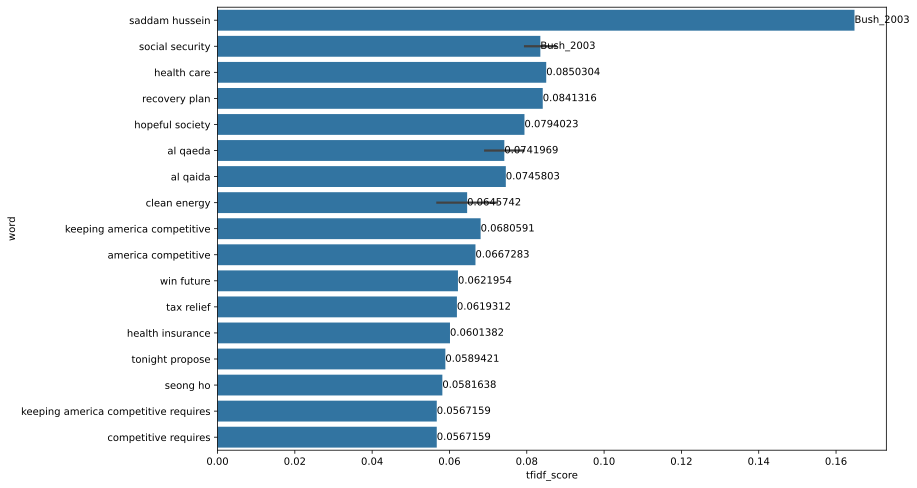

In [119]:
ax = sns.barplot(tfidf24_sub.head(20), x = "tfidf_score", y = "word")

for container, textname in zip(ax.containers, tfidf24_sub.textname):
    #print(container, textname)
    ax.bar_label(container, labels=[textname, textname])

# [Activity: Read in a different corpus, create a dataframe of info from this corpus, create a summary graphic, perform tfidf]